# Exercise 10 - Shape optimization

In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import torch
from simple_fem import FEM, Quad, import_mesh

torch.set_default_dtype(torch.double)

## Task 1 - Analysis of stress in a fillet

a) Import the mesh from a file named "mesh/fillet.vtu" using the function `import_mesh(filename, E, nu)`.

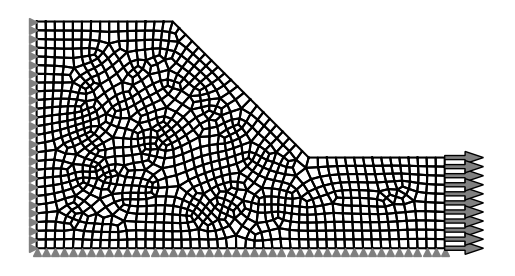

In [2]:
# Import mesh
fillet = import_mesh("mesh/fillet.vtu", 100.0, 0.25)

# Constrain left boundary
left = fillet.nodes[:, 0] == 0.0
fillet.constraints[left, 0] = True

# Constrain bottom boundary
bottom = fillet.nodes[:, 1] == 0.0
fillet.constraints[bottom, 1] = True

# Force at right boundary
right = fillet.nodes[:, 0] == 90.0
fillet.forces[right, 0] = 1.0

# Plot the fillet
fillet.plot()

b) Solve the FEM problem and plot the displacement magnitude

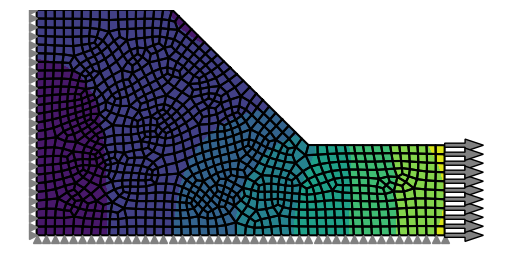

In [3]:
# Solve
u, f = fillet.solve()

# Plot
fillet.plot(u, node_property=torch.norm(u, dim=1))

c) Implement a function that takes a list of elements of the fillet and computes the v. Mises stress in those elements.

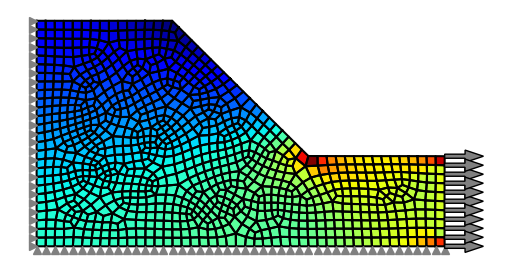

In [4]:
quad = Quad()


def mises_stress(u, elements):
    mises = []
    for element in elements:
        # Extract node positions of element
        xe = fillet.nodes[element, :]

        # Extract displacement degrees of freedom
        ue = u[element, :].ravel()

        # Set position of evaluation
        xi = [0.0, 0.0]

        # Jacobian
        J = quad.B(xi) @ xe

        # Compute B
        B = torch.linalg.inv(J) @ quad.B(xi)

        zeros = torch.zeros(quad.nodes)

        # Compute D
        D0 = torch.stack([B[0, :], zeros], dim=-1).ravel()
        D1 = torch.stack([zeros, B[1, :]], dim=-1).ravel()
        D2 = torch.stack([B[1, :], B[0, :]], dim=-1).ravel()
        D = torch.stack([D0, D1, D2])

        # Compute stress
        s = fillet.C @ D @ ue
        mises.append(torch.sqrt(s[0] ** 2 + s[1] ** 2 - s[0] * s[1] + 3 * s[2] ** 2))
    return torch.stack(mises)


# Plot the results
stress = mises_stress(u, fillet.elements)
fillet.plot(u, element_property=stress, cmap="jet")

d) Compute the maximum stress.

In [5]:
# Critical elements
critical_elements = [434, 362, 292, 128, 129, 19, 20, 21, 463, 363, 257, 177]

elements = [fillet.elements[i] for i in critical_elements]
print(max(mises_stress(u, elements)))

tensor(0.8668)


## Task 2 - Morph functions for the fillet

In [6]:
def morph(fem, mask, phi, x):
    nodes = torch.argwhere(mask)[:, 0]
    dirs = torch.argwhere(mask)[:, 1]
    M = phi[:, nodes]
    M = M[nodes, :]
    weights = torch.linalg.solve(M, x - fem.nodes[mask])
    for weight, node, dir in zip(weights, nodes, dirs):
        fem.nodes[:, dir] += weight * phi[node, :]

In [7]:
# Chosen control nodes
control_nodes = [44, 46, 49, 51, 56, 270, 274, 275]

# Mask
mask = torch.zeros_like(fillet.nodes, dtype=bool)
mask[control_nodes, 1] = True

# Initial positions
x_0 = fillet.nodes[mask].ravel()

# Precompute Gaussian radial basis functions
r = torch.cdist(fillet.nodes, fillet.nodes)
epsilon = 0.2
phi = torch.exp(-((epsilon * r) ** 2))

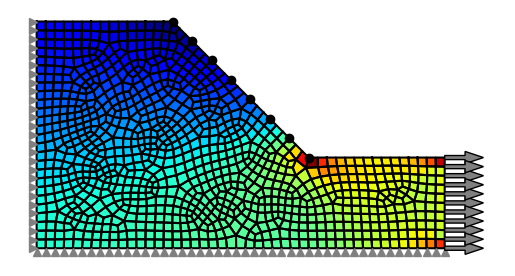

In [8]:
delta = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
morph(fillet, mask, phi, x_0 + delta)

u, f = fillet.solve()
stress = mises_stress(u, fillet.elements)

fillet.plot(element_property=stress, cmap="jet")
plt.scatter(
    fillet.nodes[control_nodes, 0].detach(),
    fillet.nodes[control_nodes, 1].detach(),
    marker="o",
    color="black",
)

## Task 3 - Optimize the fillet shape

In [9]:
def box_constrained_decent(func, x_init, x_lower, x_upper, eta=0.1, max_iter=100):
    x = x_init.clone().requires_grad_()
    for _ in range(max_iter):
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.max(torch.min(x, x_upper), x_lower)
    return x

In [10]:
def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    f_k = func(x_k)

    def approximation(x):
        res = f_k * torch.ones_like(x[..., 0])
        for j, grad in enumerate(grads):
            if grad < 0.0:
                p = 0
                q = -((x_k[j] - L_k[j]) ** 2) * grad
            else:
                p = (U_k[j] - x_k[j]) ** 2 * grad
                q = 0
            res -= p / (U_k[j] - x_k[j]) + q / (x_k[j] - L_k[j])
            res += p / (U_k[j] - x[..., j]) + q / (x[..., j] - L_k[j])
        return res

    return approximation

In [11]:
def optimize(fem, x_0, x_min, x_max, mask, iter):
    s = 0.7

    # Set up lists for L, U, x
    L = []
    U = []
    x = [x_0]

    # Precompute radial basis functions for morphing
    epsilon = 0.2
    r = torch.cdist(fillet.nodes, fillet.nodes)
    phi = torch.exp(-((epsilon * r) ** 2))

    def f(x):
        # Update nodes
        morph(fem, mask, phi, x)
        # Solve fem with updated nodes
        u_k, f_k = fem.solve()
        # Compute stress
        elements = [fem.elements[i] for i in critical_elements]
        stress = mises_stress(u_k, elements)
        # Return maximum stress
        return torch.max(stress)

    for k in range(iter):
        # Update asymptotes with heuristic procedure (see Exercise 04)
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            U_k = torch.zeros_like(U[k - 1])
            for j in range(len(L_k)):
                if (x[k][j] - x[k - 1][j]) * (x[k - 1][j] - x[k - 2][j]) < 0.0:
                    L_k[j] = x[k][j] - s * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + s * (U[k - 1][j] - x[k - 1][j])
                else:
                    L_k[j] = x[k][j] - 1.0 / sqrt(s) * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + 1.0 / sqrt(s) * (U[k - 1][j] - x[k - 1][j])
            L.append(L_k)
            U.append(U_k)
        else:
            L.append(x[k] - s * (x_max - x_min))
            U.append(x[k] + s * (x_max - x_min))

        # Compute lower move limit in this step
        x_min_k = torch.maximum(x_min, 0.9 * L[k] + 0.1 * x[k])
        x_max_k = torch.minimum(x_max, 0.9 * U[k] + 0.1 * x[k])

        # Compute the current approximation function and save gradients
        f_tilde = MMA(f, x[k], L[k], U[k])

        # Compute the maximum of the dual function
        x_star = box_constrained_decent(f_tilde, x_0, x_min_k, x_max_k, eta=0.1)
        print(x_star)

        # Compute current optimal point with dual solution
        x.append(x_star)

    return x

In [12]:
# Bounds on variables
x_min = x_0 - 5.0
x_max = x_0 + 5.0

x_opt = optimize(fillet, x_0, x_min, x_max, mask, 10)

tensor([20.9316, 24.0062, 32.8400, 37.1414, 49.9999, 28.5833, 41.4270, 45.7141],
       grad_fn=<MaximumBackward0>)
tensor([21.2005, 23.9027, 32.8406, 37.1414, 49.9999, 28.5808, 41.4271, 45.7141],
       grad_fn=<MaximumBackward0>)
tensor([21.2674, 23.8643, 32.8412, 37.1414, 49.9999, 28.5801, 41.4271, 45.7141],
       grad_fn=<MaximumBackward0>)
tensor([21.2613, 23.8543, 32.8414, 37.1414, 49.9999, 28.5802, 41.4272, 45.7141],
       grad_fn=<MaximumBackward0>)
tensor([21.3219, 23.8554, 32.8414, 37.1414, 49.9999, 28.5804, 41.4272, 45.7141],
       grad_fn=<MaximumBackward0>)
tensor([21.4332, 23.8451, 32.8415, 37.1414, 49.9999, 28.5798, 41.4272, 45.7141],
       grad_fn=<MaximumBackward0>)
tensor([21.4353, 23.8255, 32.8418, 37.1414, 49.9999, 28.5787, 41.4272, 45.7141],
       grad_fn=<MaximumBackward0>)
tensor([21.3878, 23.8253, 32.8418, 37.1414, 49.9999, 28.5791, 41.4272, 45.7141],
       grad_fn=<MaximumBackward0>)
tensor([21.4691, 23.8333, 32.8417, 37.1414, 49.9999, 28.5796, 41.4272, 4

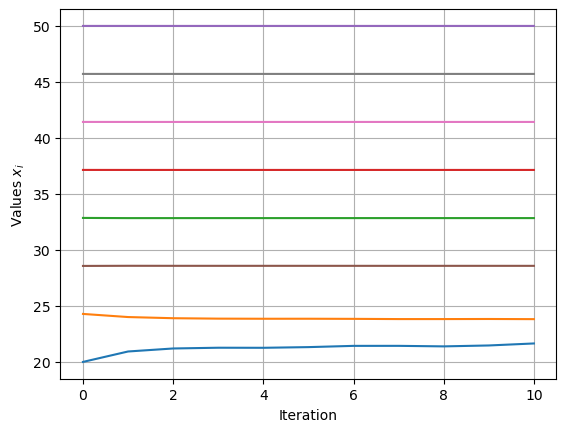

In [13]:
# Plot the development of design variables
plt.plot(torch.stack(x_opt).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $x_i$")
plt.grid()

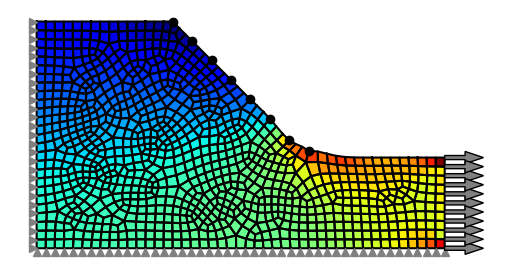

In [14]:
u, f = fillet.solve()
stress = mises_stress(u, fillet.elements)

fillet.plot(element_property=stress, cmap="jet")
plt.scatter(
    fillet.nodes[control_nodes, 0].detach(),
    fillet.nodes[control_nodes, 1].detach(), 
    marker="o",
    color="black",
)